# Converting the geopotential anomaly to a cross-stream coordinate; comparing different data sets and different time periods

In [1]:
import h5py
import netCDF4 as nc
import numpy as np
import xarray as xr

from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
import seaborn as sns

import gsw
import csaps

import warnings

sns.set_style("whitegrid")

## Hydrographic section data

In [2]:
data = loadmat('data/SR1b_section/sr1b_all.mat')

icyc = np.where(data['buf_year'] != 1999)[1] # exclude 1999
#icyc = np.where(data['buf_year'] != 1)[1] # exclude 1999

buf_gamma = data['buf_gamma'][:,icyc]
buf_lat = data['buf_lat'][0,icyc]
buf_lon = data['buf_lon'][0,icyc]
buf_phi1500 = data['buf_phi1500'][0,icyc]
buf_phi2500 = data['buf_phi2500'][0,icyc]
buf_ptmp = data['buf_ptmp'][:,icyc]
buf_sal = data['buf_sal'][:,icyc]
buf_temp = data['buf_temp'][:,icyc]
buf_year = data['buf_year'][:,icyc].reshape(316)
#buf_year = data['buf_year'][:,icyc].reshape(345)
buf_press = data['buf_press'].reshape(3000)

In [ ]:
# CALCULATE TEOS-10 UNITS (S_A, CT, )
buf_SA = gsw.SA_from_SP(buf_sal, buf_press.reshape(3000,1), buf_lon.reshape(1,316), buf_lat.reshape(1,316)) # absolute salinity
buf_CT = gsw.conversions.CT_from_t(buf_SA, buf_temp, buf_press.reshape(3000,1)) # conservative temperature

# redefine phi1500 by excluding upper ocean
gpan = -gsw.geo_strf_dyn_height(buf_SA, buf_CT, buf_press, 1500)
buf_phi1500 = abs(gpan[249,:])

# calculate distance from southern end of section
buf_dist = np.zeros(len(buf_lat))
for i in range(len(buf_lat)):
  buf_dist[i] = gsw.distance(np.mean(buf_lon)*np.ones(2), np.array([min(buf_lat), buf_lat[i]]))[0]

# fit a smoothing spline through relationship
pp_dist = csaps.csaps(buf_phi1500[np.argsort(buf_phi1500)[:-np.count_nonzero(np.isnan(buf_phi1500))]],
                      buf_dist[np.argsort(buf_phi1500)[:-np.count_nonzero(np.isnan(buf_phi1500))]],
                      smooth = 0.85)

## Recreate points along the hydrographic section

In [5]:
# sample points along the section
start_lon_vals = []
end_lon_vals = []
start_lat_vals = []
end_lat_vals = []
for yr in np.unique(buf_year):
    idx_yr = np.where(buf_year == yr)[0]
    start_lon_vals.append(np.min(buf_lon[idx_yr]))
    end_lon_vals.append(np.max(buf_lon[idx_yr]))
    start_lat_vals.append(np.max(buf_lat[idx_yr]))
    end_lat_vals.append(np.min(buf_lat[idx_yr]))
start_lon = np.mean(np.array(start_lon_vals))
end_lon = np.mean(np.array(end_lon_vals))
start_lat = np.mean(np.array(start_lat_vals))
end_lat = np.mean(np.array(end_lat_vals))

# Extract unique points along the section
nr_points = 30
lon_along_section = np.linspace(start_lon, end_lon, nr_points)
lat_along_section = np.linspace(start_lat, end_lat, nr_points)

# calculate distance from southern end of section
dist_along_section = np.zeros(len(lat_along_section))
for i in range(len(dist_along_section)):
  dist_along_section[i] = gsw.distance(np.mean(lon_along_section)*np.ones(2), np.array([min(lat_along_section), lat_along_section[i]]))[0]

## GLORYS12V1 reanalysis

In [ ]:
def get_cmems_data(years, SA_pre_calculated=True):
    """
    Get CMEMS data for the given years, optionally subsetting by year and month.
    """
    cmems = nc.Dataset('data/CMEMS_reanalysis/cmems_mod_glo_phy_my_0.083deg_P1M-m_'+years+'.nc') # downloaded on 7 July 2025
    cmems_lat = cmems.variables['latitude'][:]
    cmems_lon = cmems.variables['longitude'][:]
    cmems_depth = cmems.variables['depth'][:]
    cmems_time = cmems.variables['time'][:]
    cmems_so = cmems.variables['so'][:]
    cmems_thetao = cmems.variables['thetao'][:]
    
    idx = np.arange(len(cmems_time))
    cmems_so = cmems_so[idx,:,:,:]
    cmems_thetao = cmems_thetao[idx,:,:,:] # shape is time, depth, lat, lon

    # transform depth to pressure
    cmems_p = np.zeros((len(cmems_depth), len(cmems_lat)))
    for i in range(len(cmems_lat)):
        cmems_p[:,i] = gsw.p_from_z(-cmems_depth, cmems_lat[i])

    # interpolate p to section points
    p_section_cmems = np.zeros((len(cmems_depth), len(lat_along_section)))
    for i in range(len(cmems_depth)):
        p_section_cmems[i,:] = np.interp(lat_along_section, cmems_lat, cmems_p[i,:])

    # calculate absolute salinity and conservative temperature
    if SA_pre_calculated:
        cmems_SA = np.load('data/CMEMS_reanalysis/cmems_SA_'+years+'.npy')
    else:
        cmems_SA = np.zeros(np.shape(cmems_so))
        for t in range(len(cmems_time)):
            for d in range(len(cmems_depth)):
                for i in range(len(cmems_lat)):
                    for j in range(len(cmems_lon)):
                        cmems_SA[t,d,i,j] = gsw.SA_from_SP(cmems_so[t,d,i,j], cmems_p[d,i], cmems_lon[j], cmems_lat[i])
        np.save('data/CMEMS_reanalysis/cmems_SA_'+years+'.npy', cmems_SA)  # save pre-calculated SA
    cmems_SA = cmems_SA[idx,:,:,:]
    cmems_CT = gsw.CT_from_pt(cmems_SA, cmems_thetao)

    # interpolate SA and CT to section points
    SA_section_cmems = np.zeros((len(idx), len(cmems_depth), len(lat_along_section)))
    CT_section_cmems = np.zeros((len(idx), len(cmems_depth), len(lat_along_section)))
    points = np.array([(lat, lon) for lat,lon in zip(lat_along_section,lon_along_section)])
    for i in range(len(idx)):
        for j in range(len(cmems_depth)):
            f_SA_cmems = RegularGridInterpolator((cmems_lat, cmems_lon), cmems_SA[i,j,:,:])
            f_CT_cmems = RegularGridInterpolator((cmems_lat, cmems_lon), cmems_CT[i,j,:,:])
            SA_section_cmems[i,j,:] = f_SA_cmems(points)
            CT_section_cmems[i,j,:] = f_CT_cmems(points)

    # interpolate in p (to high resolution)
    SA_section_interp_cmems = np.zeros((len(idx), len(buf_press), len(lat_along_section)))
    CT_section_interp_cmems = np.zeros((len(idx), len(buf_press), len(lat_along_section)))
    for i in range(len(idx)):
        for j in range(len(lat_along_section)):
            f_SA_cmems = interp1d(p_section_cmems[:,j], SA_section_cmems[i,:,j], bounds_error=False, fill_value=np.nan)
            f_CT_cmems = interp1d(p_section_cmems[:,j], CT_section_cmems[i,:,j], bounds_error=False, fill_value=np.nan)
            SA_section_interp_cmems[i,:,j] = f_SA_cmems(buf_press)
            CT_section_interp_cmems[i,:,j] = f_CT_cmems(buf_press)

    # compute baroclinic streamfunction
    gpan_cmems = np.zeros((len(idx), len(buf_press), len(lat_along_section)))
    for i in range(len(idx)):
        gpan_cmems[i,:,:] = -gsw.geo_strf_dyn_height(SA_section_interp_cmems[i,:,:], CT_section_interp_cmems[i,:,:], buf_press, 1500)
    cmems_phi1500 = abs(gpan_cmems[:,249,:])

    # make spline fit through relationship between phi1500 and distance
    dist_repeat = np.tile(dist_along_section, len(cmems_time))
    cmems_phi1500_flatten = cmems_phi1500.flatten()
    pp_dist_cmems = csaps.csaps(cmems_phi1500_flatten[np.argsort(cmems_phi1500_flatten)[:-np.count_nonzero(np.isnan(cmems_phi1500_flatten))]],
                        dist_repeat[np.argsort(cmems_phi1500_flatten)[:-np.count_nonzero(np.isnan(cmems_phi1500_flatten))]],
                        smooth = 0.85)

    return SA_section_interp_cmems, CT_section_interp_cmems, gpan_cmems, cmems_phi1500, pp_dist_cmems

In [ ]:
SA_1993_all, CT_1993_all, gpan_1993_all, phi1500_1993_all, pp_dist_1993_all = get_cmems_data('1993-2005', SA_pre_calculated=True)
SA_2010_all, CT_2010_all, gpan_2010_all, phi1500_2010_all, pp_dist_2010_all = get_cmems_data('2010-2012', SA_pre_calculated=True)

## SOSE reanalysis

In [8]:
# Read in data
sose_salt_dataset = xr.open_dataset('data/SOSE_reanalysis/Salt_bsoseI155_2013to2024_monthly_DP.nc')
sose_salt = xr.DataArray(sose_salt_dataset['SALT'].values, 
                         dims=['time', 'Z', 'YC', 'XC'], 
                         coords = {'time': sose_salt_dataset['time'],
                                    'XC': sose_salt_dataset['XC'],
                                    'YC': sose_salt_dataset['YC'],
                                    'Z': sose_salt_dataset['Z']})
mask = sose_salt_dataset.maskC
sose_salt = sose_salt.where(mask)

sose_temp_dataset = xr.open_dataset('data/SOSE_reanalysis/Theta_bsoseI155_2013to2024_monthly_DP.nc')
sose_temp = xr.DataArray(sose_temp_dataset['THETA'].values, 
                         dims=['time', 'Z', 'YC', 'XC'],
                         coords = {'time': sose_temp_dataset['time'],
                                    'XC': sose_temp_dataset['XC'],
                                    'YC': sose_temp_dataset['YC'],
                                    'Z': sose_temp_dataset['Z']})
mask = sose_temp_dataset.maskC
sose_temp = sose_temp.where(mask)

sose_lat = sose_salt_dataset['YC'].values
sose_lon = sose_salt_dataset['XC'].values - 360  # convert to -180 to 180 range
sose_depth = sose_salt_dataset['Z'].values
sose_time = sose_salt_dataset['time'].values

In [9]:
# transform depth to pressure
sose_p = np.zeros((len(sose_depth), len(sose_lat)))
for i in range(len(sose_lat)):
    sose_p[:,i] = gsw.p_from_z(sose_depth, sose_lat[i])

# interpolate p to section points
p_section_sose = np.zeros((len(sose_depth), len(lat_along_section)))
for i in range(len(sose_depth)):
    p_section_sose[i,:] = np.interp(lat_along_section, sose_lat, sose_p[i,:])

In [10]:
# calculate absolute salinity and conservative temperature
# sose_SA = np.zeros(np.shape(sose_salt))
# for t in range(len(sose_time)):
#     for d in range(len(sose_depth)):
#         for i in range(len(sose_lat)):
#             for j in range(len(sose_lon)):
#                 sose_SA[t,d,i,j] = gsw.SA_from_SP(sose_salt[t,d,i,j], sose_p[d,i], sose_lon[j], sose_lat[i])
# np.save('data/SOSE_reanalysis/sose_SA.npy', sose_SA)
sose_SA = np.load('data/SOSE_reanalysis/sose_SA.npy')  # load pre-calculated SA
sose_SA = xr.DataArray(np.load('data/SOSE_reanalysis/sose_SA.npy'), 
                        dims=['time', 'depth', 'latitude', 'longitude'],
                        coords={'time': sose_time,
                                'longitude': sose_lon,
                                'latitude': sose_lat,
                                'depth': sose_depth})
sose_CT = gsw.CT_from_pt(sose_SA, sose_temp.values)

In [11]:
# interpolate p to section points
p_section_sose = np.zeros((len(sose_depth), len(lat_along_section)))
for i in range(len(sose_depth)):
    p_section_sose[i,:] = np.interp(lat_along_section, sose_lat, sose_p[i,:])

# interpolate SA and CT to section points
SA_section_sose = np.zeros((len(sose_time), len(sose_depth), len(lat_along_section)))
CT_section_sose = np.zeros((len(sose_time), len(sose_depth), len(lat_along_section)))
points = np.array([(lat, lon) for lat,lon in zip(lat_along_section,lon_along_section)])
for i in range(len(sose_time)):
    for j in range(len(sose_depth)):
        f_SA_sose = RegularGridInterpolator((sose_lat, sose_lon), sose_SA.values[i,j,:,:])
        f_CT_sose = RegularGridInterpolator((sose_lat, sose_lon), sose_CT.values[i,j,:,:])
        SA_section_sose[i,j,:] = f_SA_sose(points)
        CT_section_sose[i,j,:] = f_CT_sose(points)

# interpolate in p (to high resolution)
SA_section_interp_sose = np.zeros((len(sose_time), len(buf_press), len(lat_along_section)))
CT_section_interp_sose = np.zeros((len(sose_time), len(buf_press), len(lat_along_section)))
for i in range(len(sose_time)):
    for j in range(len(lat_along_section)):
        f_SA_sose = interp1d(p_section_sose[:,j], SA_section_sose[i,:,j], bounds_error=False, fill_value=np.nan)
        f_CT_sose = interp1d(p_section_sose[:,j], CT_section_sose[i,:,j], bounds_error=False, fill_value=np.nan)
        SA_section_interp_sose[i,:,j] = f_SA_sose(buf_press)
        CT_section_interp_sose[i,:,j] = f_CT_sose(buf_press)

In [12]:
# compute baroclinic streamfunction
gpan_sose = np.zeros((len(sose_time), len(buf_press), len(lat_along_section)))
for i in range(len(sose_time)):
    gpan_sose[i,:,:] = -gsw.geo_strf_dyn_height(SA_section_interp_sose[i,:,:], CT_section_interp_sose[i,:,:], buf_press, 1500)

sose_phi1500 = abs(gpan_sose[:,249,:])

# make spline fit through relationship between phi1500 and distance
dist_repeat = np.tile(dist_along_section, len(sose_time))
sose_phi1500_flatten = sose_phi1500.flatten()
pp_dist_sose = csaps.csaps(sose_phi1500_flatten[np.argsort(sose_phi1500_flatten)[:-np.count_nonzero(np.isnan(sose_phi1500_flatten))]],
                           dist_repeat[np.argsort(sose_phi1500_flatten)[:-np.count_nonzero(np.isnan(sose_phi1500_flatten))]],
                           smooth = 0.85)

# also do it for the subset 2013-2015
sose_phi1500_sub = sose_phi1500[0:36,:]  # select 2010-2012
sose_time_sub = sose_time[0:36]  # select 2010-2012
dist_repeat_sub = np.tile(dist_along_section, len(sose_time_sub))
sose_phi1500_flatten_sub = sose_phi1500_sub.flatten()
pp_dist_sose_sub = csaps.csaps(sose_phi1500_flatten_sub[np.argsort(sose_phi1500_flatten_sub)[:-np.count_nonzero(np.isnan(sose_phi1500_flatten_sub))]],
                           dist_repeat_sub[np.argsort(sose_phi1500_flatten_sub)[:-np.count_nonzero(np.isnan(sose_phi1500_flatten_sub))]],
                           smooth = 0.85)

/nethome/5664187/miniconda3/envs/carlo/lib/python3.13/site-packages/csaps/_sspumv.py:301: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(a, b)


## Argo data

In [13]:
argo_salt_dataset = xr.open_dataset('data/Argo_data/RG_ArgoClim_Salinity_2019.nc',decode_times=False)
argo_temp_dataset = xr.open_dataset('data/Argo_data/RG_ArgoClim_Temperature_2019.nc',decode_times=False)
argo_temp_dataset
# downloaded from https://sio-argo.ucsd.edu/RG_Climatology.html on 14 July 2025

<xarray.Dataset> Size: 2GB
Dimensions:                   (PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360,
                               TIME: 180)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 1kB 20.5 21.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 580B -64.5 -63.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 232B 2.5 10.0 ... 1.975e+03
  * TIME                      (TIME) float32 720B 0.5 1.5 2.5 ... 178.5 179.5
Data variables:
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 2GB ...
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...

In [14]:
argo_salt_mean_all = xr.DataArray(argo_salt_dataset['ARGO_SALINITY_MEAN'].values,
                                  dims = ['PRESSURE', 'LATITUDE', 'LONGITUDE'],
                                  coords = {'PRESSURE': argo_salt_dataset['PRESSURE'].values,
                                        'LATITUDE': argo_salt_dataset['LATITUDE'].values,
                                        'LONGITUDE': argo_salt_dataset['LONGITUDE'].values})
argo_salt_anom_all = xr.DataArray(argo_salt_dataset['ARGO_SALINITY_ANOMALY'].values,
                                  dims = ['TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'],
                                  coords = {'TIME': argo_salt_dataset['TIME'].values,
                                        'PRESSURE': argo_salt_dataset['PRESSURE'].values,
                                        'LATITUDE': argo_salt_dataset['LATITUDE'].values,
                                        'LONGITUDE': argo_salt_dataset['LONGITUDE'].values})

argo_temp_mean_all = xr.DataArray(argo_temp_dataset['ARGO_TEMPERATURE_MEAN'].values,
                                  dims = ['PRESSURE', 'LATITUDE', 'LONGITUDE'],
                                  coords = {'PRESSURE': argo_temp_dataset['PRESSURE'].values,
                                        'LATITUDE': argo_temp_dataset['LATITUDE'].values,
                                        'LONGITUDE': argo_temp_dataset['LONGITUDE'].values})
argo_temp_anom_all = xr.DataArray(argo_temp_dataset['ARGO_TEMPERATURE_ANOMALY'].values,
                                  dims = ['TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'],
                                  coords = {'TIME': argo_temp_dataset['TIME'].values,
                                        'PRESSURE': argo_temp_dataset['PRESSURE'].values,
                                        'LATITUDE': argo_temp_dataset['LATITUDE'].values,
                                        'LONGITUDE': argo_temp_dataset['LONGITUDE'].values})

In [15]:
# select region of interest
argo_salt_mean = argo_salt_mean_all.sel(LATITUDE=slice(-62, -53), LONGITUDE=slice(300, 307))
argo_salt_anom = argo_salt_anom_all.sel(LATITUDE=slice(-62, -53), LONGITUDE=slice(300, 307))
argo_salinity = argo_salt_anom + argo_salt_mean

argo_temp_mean = argo_temp_mean_all.sel(LATITUDE=slice(-62, -53), LONGITUDE=slice(300, 307))
argo_temp_anom = argo_temp_anom_all.sel(LATITUDE=slice(-62, -53), LONGITUDE=slice(300, 307))
argo_temperature = argo_temp_anom + argo_temp_mean

argo_time = argo_salinity['TIME'].values
argo_pressure = argo_salinity['PRESSURE'].values
argo_lat = argo_salinity['LATITUDE'].values
argo_lon = argo_salinity['LONGITUDE'].values - 360 # convert to -180 to 180 range

In [16]:
# calculate absolute salinity and conservative temperature
# argo_SA = np.zeros(np.shape(argo_salinity))
# for t in range(len(argo_time)):
#     for d in range(len(argo_pressure)):
#         for i in range(len(argo_lat)):
#             for j in range(len(argo_lon)):
#                 argo_SA[t,d,i,j] = gsw.SA_from_SP(argo_salinity[t,d,i,j], argo_pressure[d], argo_lon[j], argo_lat[i])
# np.save('data/Argo_data/Argo_SA.npy', argo_SA)
argo_SA = xr.DataArray(np.load('data/Argo_data/Argo_SA.npy'), 
                        dims=['TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'],
                        coords={'TIME': argo_time,
                                'PRESSURE': argo_pressure,
                                'LATITUDE': argo_lat,
                                'LONGITUDE': argo_lon})
argo_CT = gsw.CT_from_pt(argo_SA, argo_temperature.values)

In [17]:
# interpolate SA and CT to section points
SA_section_argo = np.zeros((len(argo_time), len(argo_pressure), len(lat_along_section)))
CT_section_argo = np.zeros((len(argo_time), len(argo_pressure), len(lat_along_section)))
points = np.array([(lat, lon) for lat,lon in zip(lat_along_section,lon_along_section)])
for i in range(len(argo_time)):
    for j in range(len(argo_pressure)):
        f_SA_argo = RegularGridInterpolator((argo_lat, argo_lon), argo_SA.values[i,j,:,:])
        f_CT_argo = RegularGridInterpolator((argo_lat, argo_lon), argo_CT.values[i,j,:,:])
        SA_section_argo[i,j,:] = f_SA_argo(points)
        CT_section_argo[i,j,:] = f_CT_argo(points)

# interpolate in p (to high resolution)
SA_section_interp_argo = np.zeros((len(argo_time), len(buf_press), len(lat_along_section)))
CT_section_interp_argo = np.zeros((len(argo_time), len(buf_press), len(lat_along_section)))
for i in range(len(argo_time)):
    for j in range(len(lat_along_section)):
        f_SA_argo = interp1d(argo_pressure, SA_section_argo[i,:,j], bounds_error=False, fill_value=np.nan)
        f_CT_argo = interp1d(argo_pressure, CT_section_argo[i,:,j], bounds_error=False, fill_value=np.nan)
        SA_section_interp_argo[i,:,j] = f_SA_argo(buf_press)
        CT_section_interp_argo[i,:,j] = f_CT_argo(buf_press)

In [18]:
# compute baroclinic streamfunction
gpan_argo = np.zeros((len(argo_time), len(buf_press), len(lat_along_section)))
for i in range(len(argo_time)):
    gpan_argo[i,:,:] = -gsw.geo_strf_dyn_height(SA_section_interp_argo[i,:,:], CT_section_interp_argo[i,:,:], buf_press, 1500)

argo_phi1500 = abs(gpan_argo[:,249,:])

# make spline fit through relationship between phi1500 and distance
dist_repeat = np.tile(dist_along_section, len(argo_time))
argo_phi1500_flatten = argo_phi1500.flatten()
pp_dist_argo = csaps.csaps(argo_phi1500_flatten[np.argsort(argo_phi1500_flatten)],
                           dist_repeat[np.argsort(argo_phi1500_flatten)],
                           smooth = 0.85)

# also do it for the subset 2010-2012
argo_phi1500_sub = argo_phi1500[6*12:8*12,:]  # select 2010-2012
argo_time_sub = argo_time[6*12:8*12]  # select 2010-2012
dist_repeat_sub = np.tile(dist_along_section, len(argo_time_sub))
argo_phi1500_flatten_sub = argo_phi1500_sub.flatten()
pp_dist_argo_sub = csaps.csaps(argo_phi1500_flatten_sub[np.argsort(argo_phi1500_flatten_sub)],
                           dist_repeat_sub[np.argsort(argo_phi1500_flatten_sub)],
                           smooth = 0.85)

/nethome/5664187/miniconda3/envs/carlo/lib/python3.13/site-packages/csaps/_sspumv.py:301: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = la.spsolve(a, b)


## The mooring data

In [19]:
# read in mooring data
mooring_c = loadmat('data/DIMES_moorings/mooring_c.mat')['mooring_c']
pressure = mooring_c['P'][0][0][0]


# downsampling to daily values
def downsample(input_array, factor):
    # factor says how much to downsample, i.e. to go from quarter hourly to days we downsample by 24*4=96
    shape = input_array.shape
    output = np.zeros((shape[0], shape[1]//factor))
    for i in range(shape[0]):
        output[i,:] = np.nanmean(input_array[i,:].reshape(-1, factor), 1)
        
    return output

downsampling_factor = 96          # 24 * 4, quarterly measurements

with warnings.catch_warnings(): # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    mooring_c['CT'][0][0] = downsample(mooring_c['CT'][0][0], downsampling_factor)
    mooring_c['SA'][0][0] = downsample(mooring_c['SA'][0][0], downsampling_factor)
    mooring_c['gamma'][0][0] = downsample(mooring_c['gamma'][0][0], downsampling_factor)
     
length_of_array = mooring_c['CT'][0][0].shape[1]


# calculate baroclinic streamfunctions and use spatial data to deduce distance from southern edge of section
gpan_c  = -gsw.geo_strf_dyn_height(mooring_c['SA'][0][0], mooring_c['CT'][0][0], mooring_c['P'][0][0][0])
phi1500_moorings  = gpan_c[105] - gpan_c[5]

## Plot all data sets together

In [20]:
g = 9.8
phi_PF = 0.55 * g
phi_SAF = 0.7 * g

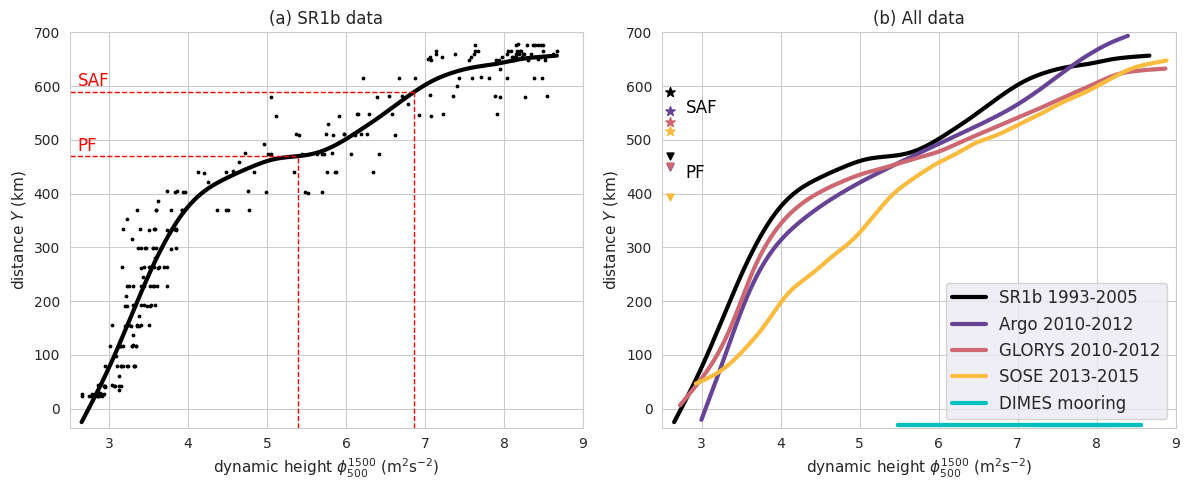

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
sns.set_style("darkgrid")
cmap = mpl.colormaps.get_cmap('cmo.thermal')
colors = cmap(np.linspace(0.3,0.85,3)) # 4-->5 if also including WOA data

# SR1b data
ax1.scatter(buf_phi1500, buf_dist/1e3, color='k', s=3)
synth_data = np.arange(np.nanmin(buf_phi1500), np.nanmax(buf_phi1500)+0.001, 0.001) # synthetic data for spline fit
ax1.plot(synth_data, pp_dist(synth_data)/1e3, color='k', lw=3) # spline fit
ax1.vlines(phi_PF, ymin=-35, ymax=pp_dist(phi_PF)/1e3, color='r', lw=1, ls='--')
ax1.hlines(pp_dist(phi_PF)/1e3, xmin=2.5, xmax=phi_PF, color='r', lw=1, ls='--')
ax1.vlines(phi_SAF, ymin=-35, ymax=pp_dist(phi_SAF)/1e3, color='r', lw=1, ls='--')
ax1.hlines(pp_dist(phi_SAF)/1e3, xmin=2.5, xmax=phi_SAF, color='r', lw=1, ls='--')
ax1.text(2.6,480,'PF',c='r',fontsize=12)
ax1.text(2.6,600,'SAF',c='r',fontsize=12)

ax2.plot(synth_data, pp_dist(synth_data)/1e3, color='k', lw=3, label='SR1b 1993-2005') # spline fit

# Argo data
synth_data_argo_sub = np.arange(np.nanmin(argo_phi1500_sub), np.nanmax(argo_phi1500_sub)+0.001, 0.001)
ax2.plot(synth_data_argo_sub, pp_dist_argo_sub(synth_data_argo_sub)/1e3, color=colors[0], lw=3, label='Argo 2010-2012')

# CMEMS data
synth_data_2010_all = np.arange(np.nanmin(phi1500_2010_all), np.nanmax(phi1500_2010_all)+0.001, 0.001)
ax2.plot(synth_data_2010_all, pp_dist_2010_all(synth_data_2010_all)/1e3, color=colors[1], lw=3, label='GLORYS 2010-2012')

# SOSE data
synth_data_sose_sub = np.arange(np.nanmin(sose_phi1500_sub), np.nanmax(sose_phi1500_sub)+0.001, 0.001)
ax2.plot(synth_data_sose_sub, pp_dist_sose(synth_data_sose_sub)/1e3, color=colors[2], lw=3, label='SOSE 2013-2015')

ax2.plot(phi1500_moorings, np.ones(len(phi1500_moorings))*-30, color='c', lw=3, label='DIMES mooring')

# Front locations
ax2.scatter(2.6,pp_dist(phi_PF)/1e3, color='k', s=25, marker = 'v')
ax2.scatter(2.6,pp_dist_argo_sub(phi_PF)/1e3, color=colors[0], s=25, marker = 'v')
ax2.scatter(2.6,pp_dist_2010_all(phi_PF)/1e3, color=colors[1], s=25, marker = 'v')
ax2.scatter(2.6,pp_dist_sose(phi_PF)/1e3, color=colors[2], s=25, marker = 'v')
ax2.scatter(2.6,pp_dist(phi_SAF)/1e3, color='k', s=50, marker = '*')
ax2.scatter(2.6,pp_dist_argo_sub(phi_SAF)/1e3, color=colors[0], s=50, marker = '*')
ax2.scatter(2.6,pp_dist_2010_all(phi_SAF)/1e3, color=colors[1], s=50, marker = '*')
ax2.scatter(2.6,pp_dist_sose(phi_SAF)/1e3, color=colors[2], s=50, marker = '*')
ax2.text(2.8,430,'PF',c='k',fontsize=12)
ax2.text(2.8,550,'SAF',c='k',fontsize=12)

for ax in [ax1,ax2]:
    ax.set_xlim(2.5,9)
    ax.set_ylim(-35, 700)
    ax.set_xlabel(r'dynamic height $\phi^{1500}_{500}$ (m$^2$s$^{-2}$)', fontsize=11)
    ax.set_ylabel(r'distance $Y$ (km)', fontsize=11)
ax2.legend(loc='lower right', fontsize=12)

ax1.set_title('(a) SR1b data', fontsize=12)
ax2.set_title('(b) All data', fontsize=12)

plt.tight_layout()
#plt.savefig('figures_paper/phi1500_sr1b_all.pdf',bbox_inches='tight')

## Showing different time periods

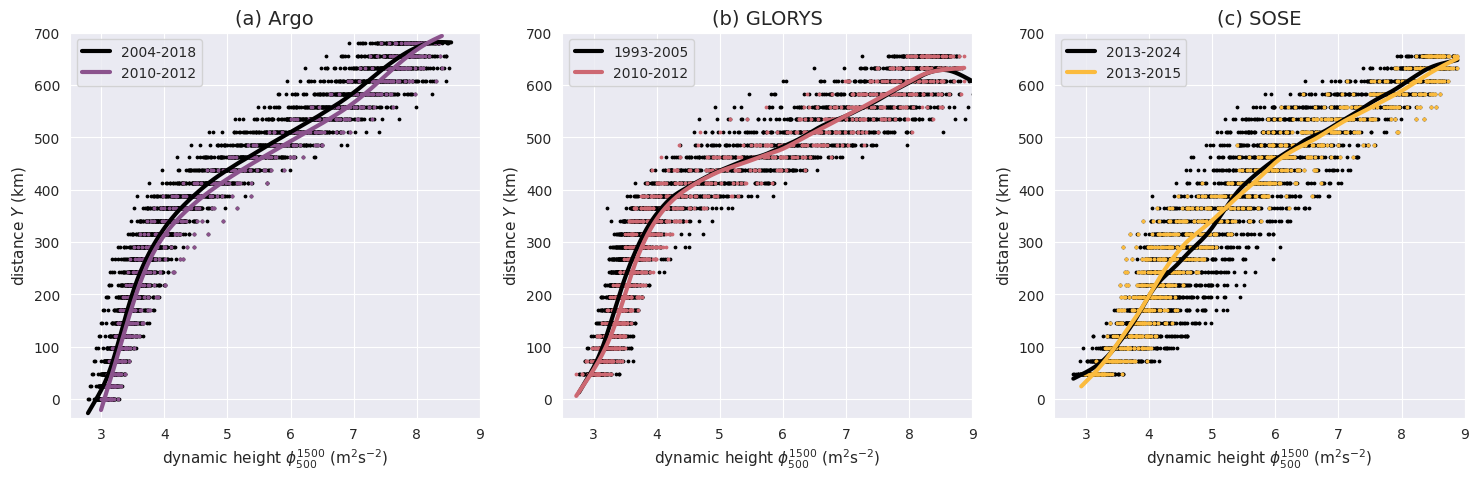

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
sns.set_style("darkgrid")

# Argo data for 2004-2018
for i in range(argo_phi1500.shape[0]):
    ax1.scatter(argo_phi1500[i,:], dist_along_section/1e3, color='k', s=3)
synth_data_argo = np.arange(np.nanmin(argo_phi1500), np.nanmax(argo_phi1500)+0.001, 0.001)
ax1.plot(synth_data_argo, pp_dist_argo(synth_data_argo)/1e3, 'k', lw=3, label='2004-2018')

# Argo data for 2010-2012
for i in range(argo_phi1500_sub.shape[0]):
    ax1.scatter(argo_phi1500_sub[i,:], dist_along_section/1e3, color=cmap(0.4), s=3)
synth_data_argo_sub = np.arange(np.nanmin(argo_phi1500_sub), np.nanmax(argo_phi1500_sub)+0.001, 0.001)
ax1.plot(synth_data_argo_sub, pp_dist_argo_sub(synth_data_argo_sub)/1e3, color=cmap(0.4), lw=3, label='2010-2012')



# GLORYS data for 1993-2005
for i in range(phi1500_1993_all.shape[0]):
    ax2.scatter(phi1500_1993_all[i,:], dist_along_section/1e3, color='k', s=3)
synth_data_cmems = np.arange(np.nanmin(phi1500_1993_all), np.nanmax(phi1500_1993_all)+0.001, 0.001)
ax2.plot(synth_data_cmems, pp_dist_1993_all(synth_data_cmems)/1e3, 'k', lw=3, label='1993-2005')

# GLORYS data for 2010-2012
for i in range(phi1500_2010_all.shape[0]):
    ax2.scatter(phi1500_2010_all[i,:], dist_along_section/1e3, color=colors[1], s=3)
synth_data_cmems_sub = np.arange(np.nanmin(phi1500_2010_all), np.nanmax(phi1500_2010_all)+0.001, 0.001)
ax2.plot(synth_data_2010_all, pp_dist_2010_all(synth_data_2010_all)/1e3, color=colors[1], lw=3, label='2010-2012')




# SOSE data for 2013-2024
for i in range(sose_phi1500.shape[0]):
    ax3.scatter(sose_phi1500[i,:], dist_along_section/1e3, color='k', s=3)
synth_data_sose = np.arange(np.nanmin(sose_phi1500), np.nanmax(sose_phi1500)+0.001, 0.001)
ax3.plot(synth_data_sose, pp_dist_sose(synth_data_sose)/1e3, 'k', lw=3, label='2013-2024')

# SOSE data for 2013-3015
for i in range(sose_phi1500_sub.shape[0]):
    ax3.scatter(sose_phi1500_sub[i,:], dist_along_section/1e3, color=colors[2], s=3)
synth_data_sose_sub = np.arange(np.nanmin(sose_phi1500_sub), np.nanmax(sose_phi1500_sub)+0.001, 0.001)
ax3.plot(synth_data_sose_sub, pp_dist_sose_sub(synth_data_sose_sub)/1e3, color=colors[2], lw=3, label='2013-2015')


for ax in [ax1,ax2,ax3]:
    ax.legend()
    ax.set_xlim(2.5,9)
    ax.set_ylim(-35, 700)
    ax.set_xlabel(r'dynamic height $\phi^{1500}_{500}$ (m$^2$s$^{-2}$)', fontsize=11)
    ax.set_ylabel(r'distance $Y$ (km)', fontsize=11)

ax1.set_title('(a) Argo',fontsize=14)
ax2.set_title('(b) GLORYS',fontsize=14)
ax3.set_title('(c) SOSE',fontsize=14)

#plt.savefig('figures_paper/phi1500_different_times.pdf',bbox_inches='tight')

plt.show()